In [1]:
import numpy as np, random, math, operator, pandas as pd, matplotlib.pyplot as plt
import time

In [2]:
random.seed(42)

# Setup

La manière dont le code fonctionne:

Il y a la classe `City` qui est en gros juste les coordonnées (x,y) de sa position, ainsi qu'une méthode pour avoir la distance.

La classe Fitness permet de, étant donné une chemin (une `route`), d'avoir la distance de ce chemin grâce à la méthode `routeDistance`, et la "Fitness" de ce chemin par la méthode `routeFitness` (qui est juste l'inverse de la distance).

Ensuite chaque agent est constitué d'un ensemble de méthodes qui permettent d'implémenter sa fonction de recherche, comme le Recuit Simulé ou bien l'algo génétique. Ces fonctions sont au final rassemblées dans la fonction `_step` qui fait une étape de l'algorithme, et la fonction `search` qui fait l'ensemble de la recherche. 
Les paramètres à donner à ces agents, tant à l'initialisation qu'à la recherche par `search`, sont variables selon l'algo utilisé par l'agent.
En particulier, un Agent est initializé avec l'information de combien d'appels à `_step` un appel à `search` va occasionner, dans `self.generations`.

In [3]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness
    
    


# Agent superclass: Search Agent

In [5]:
class SearchAgent():
    """
    Implements the `update` method common to all search agents. 
    What this method does is, according to the current agent status, decide
    what to do. 
    
    Status:
        IDLE: waits (firt state, will exit at first update() execution)
        OPTM: optimizing (finding a better solution. If stuck in local optima
              the agent will go to COMP status and wait for another agent 
              to find a better optima)
        COMP: best local solution, comparison with other agents. Will only
              exit if another agent finds a better solution
        
    """
    def __init__(self):
        self.status = "IDLE"
        self.route = None
        self.routeDistance = None
        
    def search(self):
        pass
    
    def __repr__(self):
        return self.__class__.__name__
    
    def update(self, best_other_route=None, best_other_routeDistance=None):
        """
        Does an update of the agent, according to its status
        
        Input:
            Either nothing, or
            the best current route and its distance
        Returns:
            Agent's status, current best route, current best distance
        """
        
        if self.status == "IDLE":
            self.route, self.routeDistance = self.search()
#             print(f'{self} is at distance {self.routeDistance}')
            if best_other_route is not None:
                # if another agent found a better route, take that one and 
                # goes back to optimization
                if best_other_routeDistance < self.routeDistance:
                    self.route = best_other_route
                    self.routeDistance = best_other_routeDistance
            self.status = "OPTM"
            return self.status, self.route, self.routeDistance
            
        elif self.status == "OPTM":
#             print(f'{self} is beginning at distance {self.routeDistance}')
            route, routeDistance = self.search()
#             print(f'{self} best distance found is {routeDistance}')
            # if the route distance didn't change much from last udpate() call
            if (routeDistance > 0.95 * self.routeDistance) and (routeDistance < 1.05 * self.routeDistance):
                    self.status = "COMP"
                    return self.status, self.route, self.routeDistance
            if best_other_route is not None:
                # if another agent found a better route, take that one and 
                # goes back to optimization
                if best_other_routeDistance < self.routeDistance:
                    self.route = best_other_route
                    self.routeDistance = best_other_routeDistance
                    self.status = "OPTM"
                    
                    return self.status, self.route, self.routeDistance
                
            self.route = route
            self.routeDistance = routeDistance
            return self.status, self.route, self.routeDistance
        
        elif self.status == "COMP":
            # if the current best route is provided
            if best_other_route is not None:
                # if another agent found a better route, take that one and 
                # goes back to optimization
                if best_other_routeDistance < self.routeDistance:
                    self.route = best_other_route
                    self.routeDistance = best_other_routeDistance
                    self.status = "OPTM"
                    
                    return self.status, self.route, self.routeDistance
                # else just wait for another agent to improve that solution
                else:
                    return self.status, self.route, self.routeDistance
            # this won't happen after the first iteration of the CoopAgent
            else:
                return self.status, self.route, self.routeDistance

    
        
            
        

# GAAGent

In [6]:
class GAAgent(SearchAgent):
    """
    Hyperparameters: 
        intensification: eliteSize
        diversification: popSize, mutationRate
    """
    
    def __init__(self, popSize, eliteSize, mutationRate, population, generations):
        super().__init__()
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.population = population
        self.generations = generations
    
    
    def createRoute(self, cityList):
        return random.sample(cityList, len(cityList))

    def initialPopulation(self, popSize, cityList):
        return [self.createRoute(cityList) for i in range(popSize)]

    def rankRoutes(self, population):
        fitnessResults = {i:Fitness(population[i]).routeFitness() for i in range(len(population))}
        return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

    def selection(self, popRanked, eliteSize):
        df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
        df['cum_sum'] = df.Fitness.cumsum()
        df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
        
        selectionResults = [popRanked[i][0] for i in range(eliteSize)]
        for i in range(0, len(popRanked) - eliteSize):
            pick = 100*random.random()
            for i in range(0, len(popRanked)):
                if pick <= df.iat[i,3]:
                    selectionResults.append(popRanked[i][0])
                    break
                    
        return selectionResults


    def matingPool(self, population, selectionResults):
        matingpool = [population[selectionResults[i]] for i in range(len(selectionResults))]
        return matingpool


    def breed(self, parent1, parent2):
        child = []
        childP1 = []
        childP2 = []

        geneA = int(random.random() * len(parent1))
        geneB = int(random.random() * len(parent1))

        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)

        for i in range(startGene, endGene):
            childP1.append(parent1[i])

        childP2 = [item for item in parent2 if item not in childP1]

        child = childP1 + childP2
        return child

    def breedPopulation(self, matingpool, eliteSize):
        children = []
        length = len(matingpool) - eliteSize
        pool = random.sample(matingpool, len(matingpool))

        for i in range(0,eliteSize):
            children.append(matingpool[i])

        for i in range(0, length):
            child = self.breed(pool[i], pool[len(matingpool)-i-1])
            children.append(child)
        return children


    def mutate(self, individual, mutationRate):
        for swapped in range(len(individual)):
            if(random.random() < mutationRate):
                swapWith = int(random.random() * len(individual))

                city1 = individual[swapped]
                city2 = individual[swapWith]

                individual[swapped] = city2
                individual[swapWith] = city1
        return individual


    def mutatePopulation(self, population, mutationRate):
        mutatedPop = []

        for ind in range(0, len(population)):
            mutatedInd = self.mutate(population[ind], mutationRate)
            mutatedPop.append(mutatedInd)
        return mutatedPop

    def _step(self, currentGen, eliteSize, mutationRate):
        popRanked = self.rankRoutes(currentGen)
        selectionResults = self.selection(popRanked, eliteSize)
        matingpool = self.matingPool(currentGen, selectionResults)
        children = self.breedPopulation(matingpool, eliteSize)
        nextGeneration = self.mutatePopulation(children, mutationRate)
        return nextGeneration

    def search(self):
        
        pop = self.initialPopulation(self.popSize, self.population)
        for i in range(self.generations):
            pop = self._step(pop, self.eliteSize, self.mutationRate)
        bestRouteIndex = self.rankRoutes(pop)[0][0]
        bestRoute = pop[bestRouteIndex]
        
        return bestRoute, Fitness(bestRoute).routeDistance()

## Create City List

In [7]:
def create_cityList(size=25):
    random.seed(42)
    return [City(x=int(random.random() * 1000), y=int(random.random() * 1000)) for i in range(size)]

In [36]:
cityList = create_cityList(100)

In [37]:
cityList

[(639,25),
 (275,223),
 (736,676),
 (892,86),
 (421,29),
 (218,505),
 (26,198),
 (649,544),
 (220,589),
 (809,6),
 (805,698),
 (340,155),
 (957,336),
 (92,96),
 (847,603),
 (807,729),
 (536,973),
 (378,552),
 (829,618),
 (861,577),
 (704,45),
 (227,289),
 (79,232),
 (101,277),
 (635,364),
 (370,209),
 (266,936),
 (648,609),
 (171,729),
 (163,379),
 (989,639),
 (556,684),
 (842,775),
 (229,32),
 (315,267),
 (210,942),
 (876,314),
 (655,395),
 (914,458),
 (264,246),
 (561,262),
 (584,897),
 (399,219),
 (997,509),
 (90,47),
 (109,627),
 (792,422),
 (63,381),
 (996,529),
 (971,860),
 (11,720),
 (681,536),
 (266,640),
 (111,434),
 (453,953),
 (875,263),
 (500,178),
 (912,870),
 (298,638),
 (608,152),
 (762,539),
 (778,530),
 (0,324),
 (19,929),
 (878,831),
 (307,57),
 (878,946),
 (85,485),
 (69,760),
 (765,128),
 (475,549),
 (265,872),
 (423,211),
 (539,729),
 (201,311),
 (995,649),
 (438,517),
 (121,224),
 (338,588),
 (230,220),
 (70,631),
 (228,905),
 (859,70),
 (238,668),
 (214,132),
 (9

## Test GA

In [43]:
def test_GAA(route, print_route=False):

    GAA = GAAgent(popSize=200, eliteSize=20, mutationRate=0.01, population=route, generations=500)

    chemin, E = GAA.search()
    
    if print_route: print(route)

    print(E)
    return E

In [39]:
test_GAA(cityList, print_route=True)

[(639,25), (275,223), (736,676), (892,86), (421,29), (218,505), (26,198), (649,544), (220,589), (809,6), (805,698), (340,155), (957,336), (92,96), (847,603), (807,729), (536,973), (378,552), (829,618), (861,577), (704,45), (227,289), (79,232), (101,277), (635,364), (370,209), (266,936), (648,609), (171,729), (163,379), (989,639), (556,684), (842,775), (229,32), (315,267), (210,942), (876,314), (655,395), (914,458), (264,246), (561,262), (584,897), (399,219), (997,509), (90,47), (109,627), (792,422), (63,381), (996,529), (971,860), (11,720), (681,536), (266,640), (111,434), (453,953), (875,263), (500,178), (912,870), (298,638), (608,152), (762,539), (778,530), (0,324), (19,929), (878,831), (307,57), (878,946), (85,485), (69,760), (765,128), (475,549), (265,872), (423,211), (539,729), (201,311), (995,649), (438,517), (121,224), (338,588), (230,220), (70,631), (228,905), (859,70), (238,668), (214,132), (935,571), (472,784), (807,190), (96,431), (423,467), (729,673), (984,98), (402,339), (

36980.40943018849

# RSAGent

In [12]:
class RSAgent(SearchAgent):
    """
    Hyperparameters: 
        t_init, t_min, coeff
    """
    
    def __init__(self, route_init, t_init, coeff, generations):
        super().__init__()
        self.n = len(route_init)
        self.route_init = route_init
        self.temp = t_init
        self.coeff = coeff
        self.generations = generations
    
    def _energy(self, route):
        """
        Compute energy of the route = route distance
        """
    
        return Fitness(route).routeDistance()
    
    def _step(self, route, E):
        """
        Does a step of the RS algorithm
        """
        
    
        sommet1 = random.randint(0, self.n-1)
        sommet2 = random.randint(0, self.n-1)

        route_b = route[:]

        temporaire = route_b[sommet1]
        route_b[sommet1] = route[sommet2]
        route_b[sommet2] = temporaire
        E_b = self._energy(route_b)

        if (E_b < E) or (random.random() < math.exp((E - E_b) / self.temp)):
            route = route_b
            E = E_b

        self.temp *= self.coeff
        
        return route, E
        
    
    
    def search(self):
        """

        """
        
        route = self.route_init
        E = self._energy(route)
        
        for i in range(self.generations):
            
            route, E = self._step(route, E)
            
        return route, E
        

## Test RS

In [54]:
def test_RSA(route, print_route = False):

    RSA = RSAgent(route, t_init = 100, coeff = 0.9999, generations=10000)
    
    route, E = RSA.search()
    
    if print_route: print(route)

    print(E)
    return E

In [14]:
test_RSA(cityList, print_route=True)

[(892,86), (92,96), (26,198), (79,232), (101,277), (227,289), (275,223), (340,155), (704,45), (809,6), (639,25), (421,29), (370,209), (635,364), (649,544), (861,577), (847,603), (829,618), (805,698), (736,676), (648,609), (378,552), (163,379), (218,505), (220,589), (171,729), (266,936), (536,973), (807,729), (957,336)]
5892.563641537574


5892.563641537574

# TabouAgent

In [15]:
class TAAgent(SearchAgent):
    
    
    def permutation(self,route,i,j): #renvoie le voisin associé à la permutation (i,j) 
        new_route = route.copy()
        (new_route[i],new_route[j])=(new_route[j],new_route[i])
        return(new_route)
    
    def poids (self,route): 
        return Fitness(route).routeFitness() #on cherche à maximiser le fitness qui est supérieur entre 0 (chemin
    #de longueur infinie). C'est notre fonction coût

    def __init__(self, route_init , generations):
        super().__init__()
        self.n = len(route_init)
        self.route_init = route_init
        self.generations = generations
        self.tabou = [(0,0),(1,1)]
        self.meilleur_poids_global = 0 #garde en mémoire la meilleure itération jusqu'à maintenant
        self.meilleure_route_globale=self.route_init.copy()
        
    def _step (self, route):
        
        meilleur_poids_t =0 #ces variables gardent en mémoire le meilleur voisin de la solution considérée à cette étape
        meilleure_route_t= []
        perm=(0,0) #repère la permutation
        
        for i in range (self.n):
            for j in range(i+1,self.n):
                if (i,j) not in self.tabou :
                    new_route = self.permutation(route, i,j)
                    p = self.poids (new_route)
                    if p >= meilleur_poids_t :
                        meilleur_poids_t = p
                        perm = (i,j)
                        meilleure_route_t = new_route
                        
        self.tabou.append(perm) #maj de l'ago tabou
        m = len(self.tabou)
        if m >= self.n *(self.n -1) / 2 :
            del self.tabou[0] #on se contraint à un nombre maximal de déplacements interdits pour que l'algorithme ne 
            #se retrouve pas "coincé" dans toutes les directions
        
        if meilleur_poids_t >= self.meilleur_poids_global : #si le voisin trouvé est meilleur que la solution
            #en mémoire, on met à jour cette dernière
            self.meilleure_route_globale = meilleure_route_t
            self.meilleur_poids_global=meilleur_poids_t
            self.E = Fitness(self.meilleure_route_globale).routeDistance()
        return (meilleure_route_t)
    
    def search (self):
        route = self.route_init
        for k in range (self.generations) :
            route= self._step(route) #on repart du dernier "meilleur voisin" considéré

        return self.meilleure_route_globale, Fitness(self.meilleure_route_globale).routeDistance()
   
                

## Test Tabou

In [81]:
def test_TAA(route, print_route=False):

    TAA = TAAgent(route,generations = 50)

    route, E = TAA.search()
    
    if print_route: print(route)

    print(E)
    return E

In [17]:
test_TAA(cityList, print_route=True)

[(957,336), (892,86), (809,6), (704,45), (639,25), (421,29), (220,589), (171,729), (266,936), (536,973), (807,729), (805,698), (829,618), (847,603), (861,577), (736,676), (648,609), (635,364), (370,209), (340,155), (275,223), (227,289), (101,277), (79,232), (92,96), (26,198), (163,379), (218,505), (378,552), (649,544)]
5216.083513325712


5216.083513325712

# CoopAgent

In [18]:
class CoopAgent():
    """
    This agent is the one that's creating and coordinating all the other agent
    work. 
    It first create the agents with various parameters, and then goes through
    cycles of updates to make the agents cooperate according to their status
    """
    
    def __init__(self, agents, nb_cycles):
        self.agents = agents
        self.nb_cycles = nb_cycles
        self.bestRoute = None
        self.bestRouteDistance = None
    
    
    def cycle(self, print_cycles=False):
        counter = 0
        for cycle in range(self.nb_cycles):
            if print_cycles: 
                print(f'Currently at cycle number {cycle}')
            for agent in self.agents:

                start = time.time()
                status, route, distance = agent.update(self.bestRoute, self.bestRouteDistance)
                end = time.time()
#                 print(f'Time taken by agent {agent} is: {end-start}')
                if (not self.bestRouteDistance) or distance < self.bestRouteDistance:
                    if print_cycles:
                        print('-------------------------------')
                        print(f'New best route found by {agent}, with distance {distance}')
                        print('-------------------------------')
                    self.bestRoute = route
                    self.bestRouteDistance = distance
                else:
                    counter += 1
            if counter > len(self.agents)*2:
                print("No more best route found")
                break
                

## Test coop

In [19]:
def test_CoopA(cityList, intensity=1):
    
    TAA1 = TAAgent(cityList, generations=20*intensity)
    RSA1 = RSAgent(cityList, t_init = 100, coeff = 0.99, generations=500* intensity)    
    GAA1 = GAAgent(popSize=50, eliteSize=10, mutationRate=0.03, population=cityList, generations=10*intensity)

    agents = [TAA1, RSA1, GAA1]
    
    CoopA = CoopAgent(agents, 30)
    
    CoopA.cycle(print_cycles=True)

In [20]:
cityList = create_cityList(30)

In [21]:
test_CoopA(cityList, intensity=2)

Currently at cycle number 0
-------------------------------
New best route found by TAAgent, with distance 5414.097856701884
-------------------------------
-------------------------------
New best route found by RSAgent, with distance 4880.521982290669
-------------------------------
Currently at cycle number 1
Currently at cycle number 2
No more best route found


In [44]:
def time_AG():
    taille_ville = [5, 10, 25, 50, 75, 100, 300]
    times = []
    for taille in taille_ville:
        cityList = create_cityList(taille)
        start = time.time()
        E = test_GAA(cityList)
        end = time.time()
        print(E)
        times.append(end-start)
        print(f'{taille} a pris {end-start}s')
    return times

In [45]:
times_AG = time_AG()

1977.6826052673102
1977.6826052673102
5 a pris 38.948495388031006s
2643.2651652083136
2643.2651652083136
10 a pris 37.84554982185364s
3872.0146659134757
3872.0146659134757
25 a pris 40.8398814201355s
13035.4613570789
13035.4613570789
50 a pris 49.999741077423096s
24142.961017186342
24142.961017186342
75 a pris 57.66526937484741s
36462.72210885223
36462.72210885223
100 a pris 65.35279250144958s
130311.55248836077
130311.55248836077
300 a pris 131.44264912605286s


In [55]:
def time_RS():
    taille_ville = [5, 10, 25, 50, 75, 100, 300]
    times = []
    for taille in taille_ville:
        cityList = create_cityList(taille)
        start = time.time()
        E = test_RSA(cityList)
        end = time.time()
        print(E)
        times.append(end-start)
        print(f'{taille} a pris {end-start}s')
    return times

In [56]:
times_RS = time_RS()

1977.6826052673105
1977.6826052673105
5 a pris 0.1757962703704834s
2719.0596258101014
2719.0596258101014
10 a pris 0.2945592403411865s
4030.9681467847154
4030.9681467847154
25 a pris 0.6301424503326416s
8540.18486798297
8540.18486798297
50 a pris 1.1945033073425293s
12012.291100069648
12012.291100069648
75 a pris 1.7892112731933594s
16031.595257446745
16031.595257446745
100 a pris 2.366360902786255s
56474.13973201569
56474.13973201569
300 a pris 7.1774256229400635s


In [82]:
def time_Tabou():
    taille_ville = [5, 10, 25, 50, 75, 100, 300]
    times = []
    for taille in taille_ville:
        cityList = create_cityList(taille)
        start = time.time()
        E = test_TAA(cityList)
        end = time.time()
        print(E)
        times.append(end-start)
        print(f'{taille} a pris {end-start}s')
    return times
        

In [ ]:
times_Tabou = time_Tabou()

1977.6826052673102
1977.6826052673102
5 a pris 0.0030562877655029297s
2643.2651652083146
2643.2651652083146
10 a pris 0.043688058853149414s
4642.269409099277
4642.269409099277
25 a pris 0.840411901473999s
8331.110794137547
8331.110794137547
50 a pris 7.217057466506958s
14012.97820255808
14012.97820255808
75 a pris 24.48953366279602s
18337.465545764317
18337.465545764317
100 a pris 58.762179136276245s


In [46]:
def time_coop():
    taille_ville = [5, 10, 25, 50, 75, 100, 300]
    times = []
    for taille in taille_ville:
        cityList = create_cityList(taille)
        start = time.time()
        test_CoopA(cityList, intensity = max(2,taille//60))
        end = time.time()
        times.append(end-start)
        print(f'{taille} a pris {end-start}s')
    return times
        

In [47]:
times_coop = time_coop()

Currently at cycle number 0
-------------------------------
New best route found by TAAgent, with distance 1977.6826052673102
-------------------------------
Currently at cycle number 1
Currently at cycle number 2
No more best route found
5 a pris 0.2968888282775879s
Currently at cycle number 0
-------------------------------
New best route found by TAAgent, with distance 2643.2651652083146
-------------------------------
-------------------------------
New best route found by RSAgent, with distance 2643.265165208314
-------------------------------
Currently at cycle number 1
Currently at cycle number 2
No more best route found
10 a pris 0.3560972213745117s
Currently at cycle number 0
-------------------------------
New best route found by TAAgent, with distance 4642.269409099277
-------------------------------
Currently at cycle number 1
Currently at cycle number 2
No more best route found
25 a pris 2.007897138595581s
Currently at cycle number 0
-------------------------------
New bes

KeyboardInterrupt: 

In [60]:
taille_ville = [5, 10, 25, 50, 75, 100, 300]

Text(0.5, 1.0, 'Algorithme génétique')

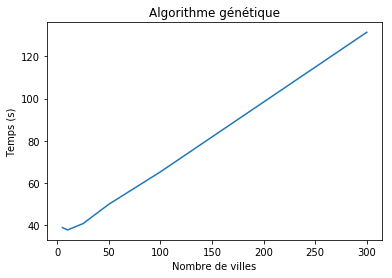

In [70]:
plt.plot(taille_ville, times_AG)
plt.xlabel("Nombre de villes")
plt.ylabel("Temps (s)")
plt.title("Algorithme génétique")

Text(0.5, 1.0, 'Recuit simulé')

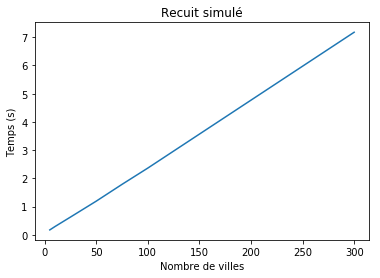

In [71]:
plt.plot(taille_ville, times_RS)
plt.xlabel("Nombre de villes")
plt.ylabel("Temps (s)")
plt.title("Recuit simulé")

Text(0.5, 1.0, 'Tabou')

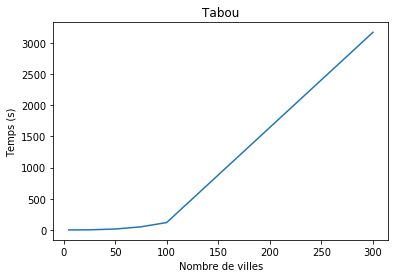

In [72]:
plt.plot(taille_ville, times_Tabou)
plt.xlabel("Nombre de villes")
plt.ylabel("Temps (s)")
plt.title("Tabou")

In [73]:
times_AG

[38.948495388031006,
 37.84554982185364,
 40.8398814201355,
 49.999741077423096,
 57.66526937484741,
 65.35279250144958,
 131.44264912605286]

In [74]:
times_coop = [0.2968888282775879, 0.3560972213745117,  2.007897138595581, 12.524741411209106, 41.057693004608154,  95.62084603309631 ]

Text(0.5, 1.0, 'Coopération')

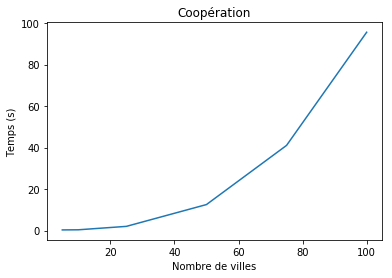

In [75]:
plt.plot(taille_ville[:-1], times_coop)
plt.xlabel("Nombre de villes")
plt.ylabel("Temps (s)")
plt.title("Coopération")

Text(0.5, 1.0, 'Tabou')

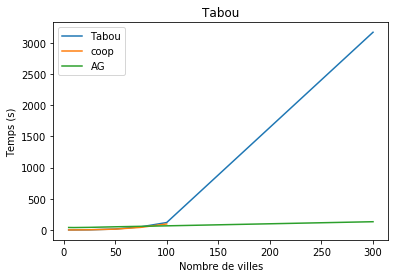

In [80]:
plt.plot(taille_ville, times_Tabou, label='Tabou')
plt.plot(taille_ville[:-1], times_coop, label='coop')
plt.plot(taille_ville, times_AG, label='AG')
plt.legend()
plt.xlabel("Nombre de villes")
plt.ylabel("Temps (s)")
plt.title("Tabou")